In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import os
import sys
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import pyarrow.parquet as pq
from matplotlib.backends.backend_pdf import PdfPages 
from matplotlib.path import Path
from enum import Enum
from typing import Union

import gc
gc.collect()

378

In [36]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()
sys.path.append('/groups/icecube/cyan/factory/DOMification')
from Enum.Flavour import Flavour
from Enum.EnergyRange import EnergyRange
from EventPeek.PseudoNormaliser import PseudoNormaliser

In [37]:
# root_dir_noCR_CC_IN = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied_filtered_third_round/Snowstorm/CC_CRclean_Contained/"
root_dir = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied_third/Snowstorm/"
er = EnergyRange.ER_10_TEV_1_PEV
flavour = Flavour.MU
# dir_TeV_nu_mu_1_1 = os.path.join(root_dir, EnergyRange.get_subdir(er, flavour), "1", "PMTfied_1.parquet")
dir_TeV_nu_mu_1_truth = os.path.join(root_dir, EnergyRange.get_subdir(er, flavour), "truth_1.parquet")
dir_TeV_nu_e_1_truth = os.path.join(root_dir, EnergyRange.get_subdir(er, Flavour.E), "truth_1.parquet")
dir_TeV_nu_tau_1_truth = os.path.join(root_dir, EnergyRange.get_subdir(er, Flavour.TAU), "truth_1.parquet")

In [38]:
def convertParquetToDF(file:str) -> pd.DataFrame:
    table = pq.read_table(file)
    df = table.to_pandas()
    return df

In [39]:
df_TeV_nu_mu_1_truth = convertParquetToDF(dir_TeV_nu_mu_1_truth)
df_TeV_nu_e_1_truth = convertParquetToDF(dir_TeV_nu_e_1_truth)
df_TeV_nu_tau_1_truth = convertParquetToDF(dir_TeV_nu_tau_1_truth)

In [40]:
ICECUBE_SIDE_CORNERS = {
    0: np.array([(269.70961549, 548.30058428, 524.56), (269.70961549, 548.30058428, -512.82),
                    (576.36999512, 170.91999817, 524.56), (576.36999512, 170.91999817, -512.82)]),
    1: np.array([(576.36999512, 170.91999817, 524.56), (576.36999512, 170.91999817, -512.82),
                    (361.0, -422.82998657, 524.56), (361.0, -422.82998657, -512.82)]),
    2: np.array([(361.0, -422.82998657, 524.56), (361.0, -422.82998657, -512.82),
                    (-256.14001465, -521.08001709, 524.56), (-256.14001465, -521.08001709, -512.82)]),
    3: np.array([(-256.14001465, -521.08001709, 524.56), (-256.14001465, -521.08001709, -512.82),
                    (-570.90002441, -125.13999939, 524.56), (-570.90002441, -125.13999939, -512.82)]),
    4: np.array([(-570.90002441, -125.13999939, 524.56), (-570.90002441, -125.13999939, -512.82),
                    (-347.88000488, 451.51998901, 524.56), (-347.88000488, 451.51998901, -512.82)]),
    5: np.array([(-347.88000488, 451.51998901, 524.56), (-347.88000488, 451.51998901, -512.82),
                    (269.70961549, 548.30058428, 524.56), (269.70961549, 548.30058428, -512.82)]),
    }
ICECUBE_BASE_CORNERS = {
    0: np.array([(269.70961549, 548.30058428, -512.82), 
                 (576.36999512, 170.91999817, -512.82),
                (361.0, -422.82998657, -512.82), 
                (-256.14001465, -521.08001709, -512.82),
                (-570.90002441, -125.13999939, -512.82),
                (-347.88000488, 451.51998901, -512.82)]),
    1: np.array([(269.70961549, 548.30058428, 524.56),
                (576.36999512, 170.91999817, 524.56),
                (361.0, -422.82998657, 524.56), 
                (-256.14001465, -521.08001709, 524.56),
                (-570.90002441, -125.13999939, 524.56),
                (-347.88000488, 451.51998901, 524.56)]),
    }

In [41]:
def check_intersection_containment_one_side(intersection: np.ndarray, 
                                            corner_set: np.ndarray) -> bool:
    p0, p1, p2 = corner_set[:3]
    v1 = p1 - p0
    v2 = p2 - p0
    normal = np.cross(v1, v2)
    normal /= np.linalg.norm(normal)

    # Orthonormal basis vectors in the plane
    u = v1 / np.linalg.norm(v1)
    w = np.cross(normal, u)

    def project_to_plane(pt):
        vec = pt - p0
        return np.dot(vec, u), np.dot(vec, w)

    # Project the corners and the intersection
    polygon_2d = np.array([project_to_plane(c) for c in corner_set])
    point_2d = project_to_plane(intersection)

    # Use 2D polygon containment check with numerical tolerance
    return Path(polygon_2d, closed=True).contains_point(point_2d, radius=1e-8)


In [42]:
def compute_intersection_with_plane(pos: np.ndarray, 
                                    direction: np.ndarray, 
                                    corner_set: np.ndarray) -> Union[np.ndarray, None]:
    corner_0, corner_1, corner_2 = corner_set[:3]
    edge01 = corner_1 - corner_0
    edge12 = corner_2 - corner_1
    normal = np.cross(edge01, edge12)
    normal /= np.linalg.norm(normal)

    denom = np.dot(normal, direction)
    if abs(denom) < 1e-12:  # Line is parallel to plane
        return None

    t = np.dot(normal, corner_0 - pos) / denom
    intersection = pos + t * direction
    return intersection


In [43]:
def find_line_prism_intersections(pos: np.ndarray, direction: np.ndarray) -> list:
    MAX_VALID_DISTANCE = 2000
    ICECUBE_SIDE_CORNERS = {
        0: np.array([(269.70961549, 548.30058428, 524.56), (269.70961549, 548.30058428, -512.82),
                        (576.36999512, 170.91999817, 524.56), (576.36999512, 170.91999817, -512.82)]),
        1: np.array([(576.36999512, 170.91999817, 524.56), (576.36999512, 170.91999817, -512.82),
                        (361.0, -422.82998657, 524.56), (361.0, -422.82998657, -512.82)]),
        2: np.array([(361.0, -422.82998657, 524.56), (361.0, -422.82998657, -512.82),
                        (-256.14001465, -521.08001709, 524.56), (-256.14001465, -521.08001709, -512.82)]),
        3: np.array([(-256.14001465, -521.08001709, 524.56), (-256.14001465, -521.08001709, -512.82),
                        (-570.90002441, -125.13999939, 524.56), (-570.90002441, -125.13999939, -512.82)]),
        4: np.array([(-570.90002441, -125.13999939, 524.56), (-570.90002441, -125.13999939, -512.82),
                        (-347.88000488, 451.51998901, 524.56), (-347.88000488, 451.51998901, -512.82)]),
        5: np.array([(-347.88000488, 451.51998901, 524.56), (-347.88000488, 451.51998901, -512.82),
                        (269.70961549, 548.30058428, 524.56), (269.70961549, 548.30058428, -512.82)]),
    }
    ICECUBE_BASE_CORNERS = {
        0: np.array([(269.70961549, 548.30058428, -512.82), 
                    (576.36999512, 170.91999817, -512.82),
                    (361.0, -422.82998657, -512.82), 
                    (-256.14001465, -521.08001709, -512.82),
                    (-570.90002441, -125.13999939, -512.82),
                    (-347.88000488, 451.51998901, -512.82)]),
        1: np.array([(269.70961549, 548.30058428, 524.56),
                    (576.36999512, 170.91999817, 524.56),
                    (361.0, -422.82998657, 524.56), 
                    (-256.14001465, -521.08001709, 524.56),
                    (-570.90002441, -125.13999939, 524.56),
                    (-347.88000488, 451.51998901, 524.56)]),
        }
    intersections = []
    hypothetical_intersections = []
    for face_corners in list(ICECUBE_SIDE_CORNERS.values()) + list(ICECUBE_BASE_CORNERS.values()):
        point = compute_intersection_with_plane(pos, direction, face_corners)
        hypothetical_intersections.append(point)
        if point is not None and check_intersection_containment_one_side(point, face_corners):
            if np.linalg.norm(point - pos) < MAX_VALID_DISTANCE:
                intersections.append(point)

    return intersections, hypothetical_intersections


In [44]:
CECUBE_BASE_CORNERS_Bottom = {
    0: np.array([269.70961549, 548.30058428, -512.82]),
    1: np.array([576.36999512, 170.91999817, -512.82]),
    2: np.array([361.0, -422.82998657, -512.82]),
    3: np.array([-256.14001465, -521.08001709, -512.82]),
    4: np.array([-570.90002441, -125.13999939, -512.82]),
    5: np.array([-347.88000488, 451.51998901, -512.82])
}
# Your new hexagon data
# Using keys 0-5 for consistency, assuming the list implies order
ICECUBE_TOP_CORNERS_top = {
    0: np.array([269.70961549, 548.30058428, 524.56]),
    1: np.array([576.36999512, 170.91999817, 524.56]),
    2: np.array([361.0, -422.82998657, 524.56]),
    3: np.array([-256.14001465, -521.08001709, 524.56]),
    4: np.array([-570.90002441, -125.13999939, 524.56]),
    5: np.array([-347.88000488, 451.51998901, 524.56])
}

In [45]:
def is_point_inside_hexagon(pos: np.ndarray,
                            hexagon_data):
    sorted_keys = sorted(hexagon_data.keys())
    hexagon_vertices_3d = [np.asarray(hexagon_data[k]) for k in sorted_keys]
    # 2. Extract 2D vertices (X, Y)
    hexagon_vertices_2d = np.array([[v[0], v[1]] for v in hexagon_vertices_3d])
    hexagon_path = Path(hexagon_vertices_2d)
    # --- Check the Point ---
    x, y, z = point_xyz
    is_inside = hexagon_path.contains_point((x, y))
    return is_inside

In [ ]:
def compute_prism_travel_distance(pos: np.ndarray, direction: np.ndarray) -> float:
    intersections, hypothetical_intersections = find_line_prism_intersections(pos, direction) # can return 0, 1, or 2 intersections

    v_norm_sq = np.dot(direction, direction)
    t_values = [(np.dot(p - pos, direction) / v_norm_sq, p) for p in intersections]
    """
    Project each intersection point onto the line using parameter t,
    where t = 0 corresponds to the interaction vertex.
    The sign and magnitude of t indicate the point’s position along the line:
    
    L(t) = P0 + t * v, where P0 is the interaction vertex and v is the direction vector.
    t = (p-P0)·v / |v|^2 : projection of p onto the line
    if t < 0, the point is before the interaction vertex; if t > 0, it is after the vertex.
    smaller t → earlier (entry), larger t → later (exit).
    """

    if len(t_values) == 2:
        t_values.sort(key=lambda x: x[0])
        (t1, p1), (t2, p2) = t_values # t1 < t2
        if t1 >= 0: 
            # both points are after the interaction vertex,
            # include the full distance between p1 and p2
            prism_travel_distance = np.linalg.norm(p2 - p1)
            
        elif t2 > 0: # t1<0
            # only p2 is after the interaction vertex,
            # only take the distance from the vertex to p2
            prism_travel_distance = np.linalg.norm(p2 - pos)
                    
        else: # t1<0 and t2<=0
            prism_travel_distance = 0.0
            
    elif len(t_values) == 1: # i dont think this case is possible
        (t, p) = t_values[0]
        if t >= 0:
            dist = np.linalg.norm(p - pos)
            prism_travel_distance = dist if dist > 1e-3 else 0.0
        else:
            prism_travel_distance = 0.0

    else: # no or infinite intersection
        prism_travel_distance = 0.0
    
    return prism_travel_distance


In [47]:
def show_intersections(df: pd.DataFrame, max_events: int = 2000):
    events_with_more_than_2 = []
    two_intersections = []
    single_intersection = []
    no_intersection = []

    for idx, row in df.head(max_events).iterrows():
        event_no = row['event_no']
        pos = np.array([
            row['pos_x_GNHighestEDaughter'],
            row['pos_y_GNHighestEDaughter'],
            row['pos_z_GNHighestEDaughter']
        ])
        direction = np.array([
            row['dir_x_GNHighestEDaughter'],
            row['dir_y_GNHighestEDaughter'],
            row['dir_z_GNHighestEDaughter']
        ])

        intersections = find_line_prism_intersections(pos, direction)

        # print(f"\n🧊 Event {event_no:.0f}")
        # print(f"Vertex: {np.round(pos, 2)}")
        # print(f"Direction: {np.round(direction, 3)}")
        # print(f"→ {len(intersections)} intersections:")
        # for i, p in enumerate(intersections):
        #     print(f"  {i+1}: {np.round(p, 2)}  (|p - vertex| = {np.linalg.norm(p - pos):.2f} m)")

        if len(intersections) > 2:
            print("⚠️  More than 2 intersections found!")
            events_with_more_than_2.append(event_no)
        elif len(intersections) == 2:
            two_intersections.append(event_no)
        elif len(intersections) == 1:
            single_intersection.append(event_no)
        else:
            no_intersection.append(event_no)

    print(f"Events with more than 2 intersections: {len(events_with_more_than_2)}")
    print(f"Events with 2 intersections: {len(two_intersections)}")
    print(f"Events with 1 intersection: {len(single_intersection)}")
    print(f"Events with no intersection: {len(no_intersection)}")
    print(f"Total events checked: {max_events}")


In [48]:
show_intersections(df_TeV_nu_mu_1_truth, max_events=2000)
# 2000 events: 7 sec

Events with more than 2 intersections: 0
Events with 2 intersections: 2000
Events with 1 intersection: 0
Events with no intersection: 0
Total events checked: 2000


In [53]:
def plot_intersections_and_vertex_debug(pos: np.ndarray, 
                                        direction: np.ndarray, 
                                        result: dict, 
                                        hypothetical_intersections: list, 
                                        elev=75, azim=240):
    
    border_xy = np.array(
    [
        (-256.1400146484375, -521.0800170898438),
        (-132.8000030517578, -501.45001220703125),
        (-9.13000011444092, -481.739990234375),
        (114.38999938964844, -461.989990234375),
        (237.77999877929688, -442.4200134277344),
        (361.0, -422.8299865722656),
        (405.8299865722656, -306.3800048828125),
        (443.6000061035156, -194.16000366210938),
        (500.42999267578125, -58.45000076293945),
        (544.0700073242188, 55.88999938964844),
        (576.3699951171875, 170.9199981689453),
        (505.2699890136719, 257.8800048828125),
        (429.760009765625, 351.0199890136719),
        (338.44000244140625, 463.7200012207031),
        (224.5800018310547, 432.3500061035156),
        (101.04000091552734, 412.7900085449219),
        (22.11000061035156, 509.5),
        (-101.05999755859375, 490.2200012207031),
        (-224.08999633789062, 470.8599853515625),
        (-347.8800048828125, 451.5199890136719),
        (-392.3800048828125, 334.239990234375),
        (-437.0400085449219, 217.8000030517578),
        (-481.6000061035156, 101.38999938964844),
        (-526.6300048828125, -15.60000038146973),
        (-570.9000244140625, -125.13999938964844),
        (-492.42999267578125, -230.16000366210938),
        (-413.4599914550781, -327.2699890136719),
        (-334.79998779296875, -424.5),
    ]
    )
    border_z = np.array([-512.82, 524.56])

    fig, ax = plt.subplots(figsize=(21, 13), subplot_kw={'projection': '3d'})

    # Plot interaction vertex
    ax.scatter(*pos, color='black', marker='x', s=100, label='Vertex')
    ax.text(*pos, f"V\n({pos[0]:.1f}, {pos[1]:.1f}, {pos[2]:.1f})", fontsize=9, color='black')

    # Plot valid intersections
    if result["i1"] is not None:
        ax.scatter(*result["i1"], color='blue', s=100, label='Intersection 1')
        ax.text(*result["i1"], f"I1\n({result['i1'][0]:.1f}, {result['i1'][1]:.1f}, {result['i1'][2]:.1f})", fontsize=9, color='blue')
    if result["i2"] is not None:
        ax.scatter(*result["i2"], color='green', s=100, label='Intersection 2')
        ax.text(*result["i2"], f"I2\n({result['i2'][0]:.1f}, {result['i2'][1]:.1f}, {result['i2'][2]:.1f})", fontsize=9, color='green')

    # Plot hypothetical intersections
    for i, point in enumerate(hypothetical_intersections):
        if point is not None:
            ax.scatter(*point, color='red', s=60, alpha=0.4, label='Hypothetical' if i == 0 else None)
            ax.text(*point, f"H{i}\n({point[0]:.1f}, {point[1]:.1f}, {point[2]:.1f})", fontsize=8, color='red')

    # Direction line
    t_vals = np.linspace(-500, 500, 2)
    line = pos[None, :] + t_vals[:, None] * direction
    ax.plot(line[:, 0], line[:, 1], line[:, 2], linestyle='--', color='gray', alpha=0.5)

    # Draw prism borders
    for x, y in border_xy:
        ax.plot([x, x], [y, y], border_z, color='cyan', alpha=0.5, linestyle='-')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title("Vertex and Intersections")
    ax.view_init(elev=elev, azim=azim)
    ax.legend()
    plt.show()

In [54]:
pec_events =[111000100000006, 111000100000027, 111000100000057, 111000100000077, 111000100000087, 111000100000093,111000100000106]

In [55]:
def show_peculiar_events(df: pd.DataFrame):
    pec_events =[111000100000006, 111000100000027, 111000100000057, 111000100000077, 111000100000087, 111000100000093,111000100000106]
    
    for event_no in pec_events:
        print(f"\n🧊 Event number: {event_no}")
        df_event = df[df['event_no'] == event_no].iloc[0]

        # Diagnostic block
        pos = np.array([
            df_event['pos_x_GNHighestEDaughter'], 
            df_event['pos_y_GNHighestEDaughter'], 
            df_event['pos_z_GNHighestEDaughter']
        ])
        dir = np.array([
            df_event['dir_x_GNHighestEDaughter'], 
            df_event['dir_y_GNHighestEDaughter'], 
            df_event['dir_z_GNHighestEDaughter']
        ])
        result, hypothetical_intersections = compute_prism_travel_distance(pos, dir)
        plot_intersections_and_vertex_debug(pos, dir, result, hypothetical_intersections)


🧊 Event number: 111000100000006


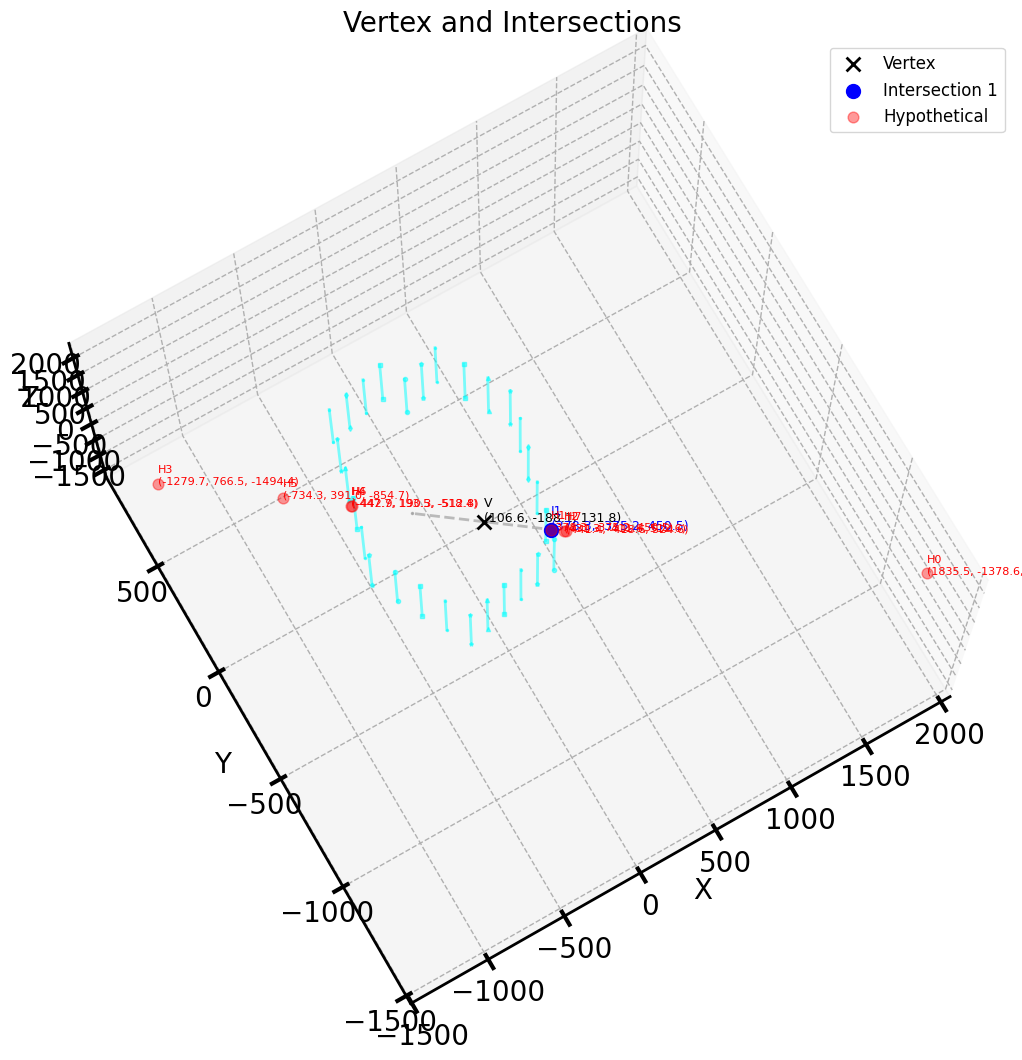


🧊 Event number: 111000100000027


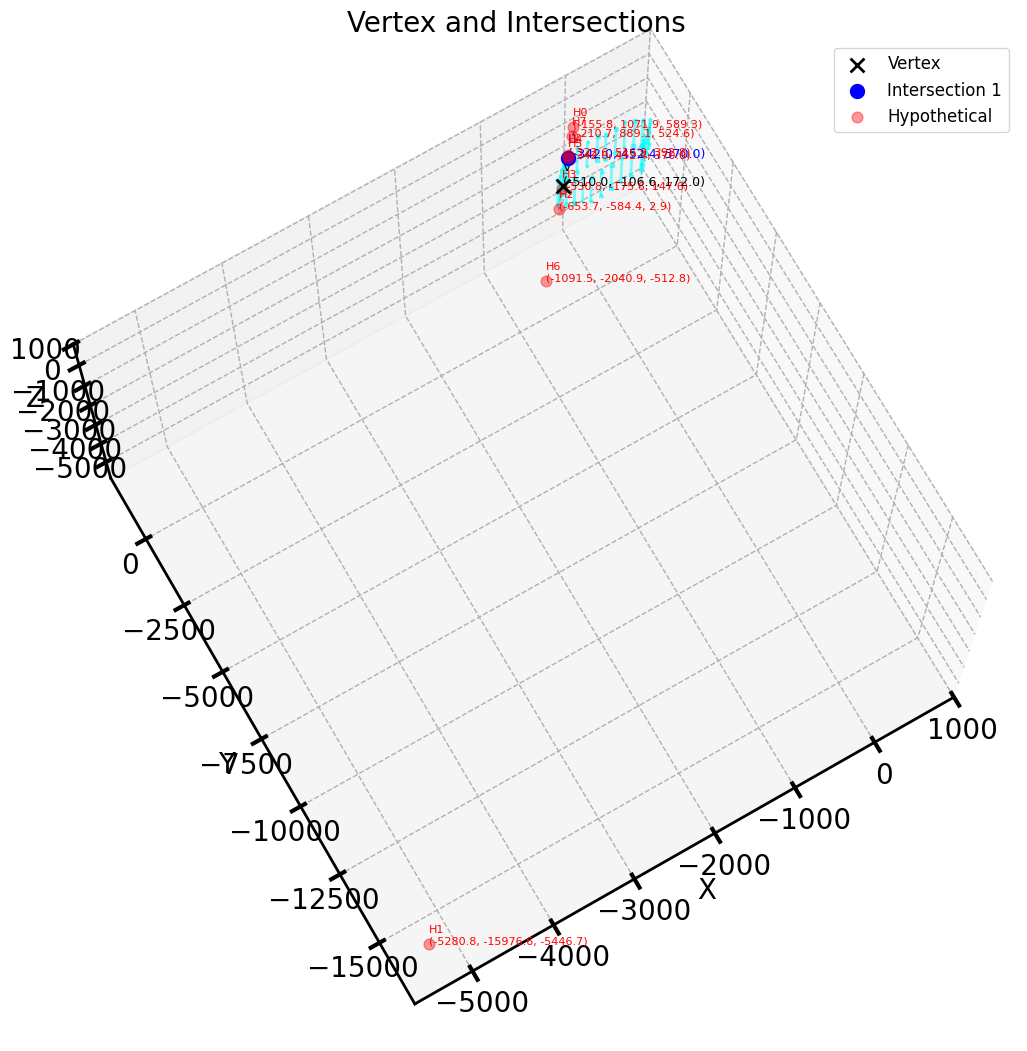


🧊 Event number: 111000100000057


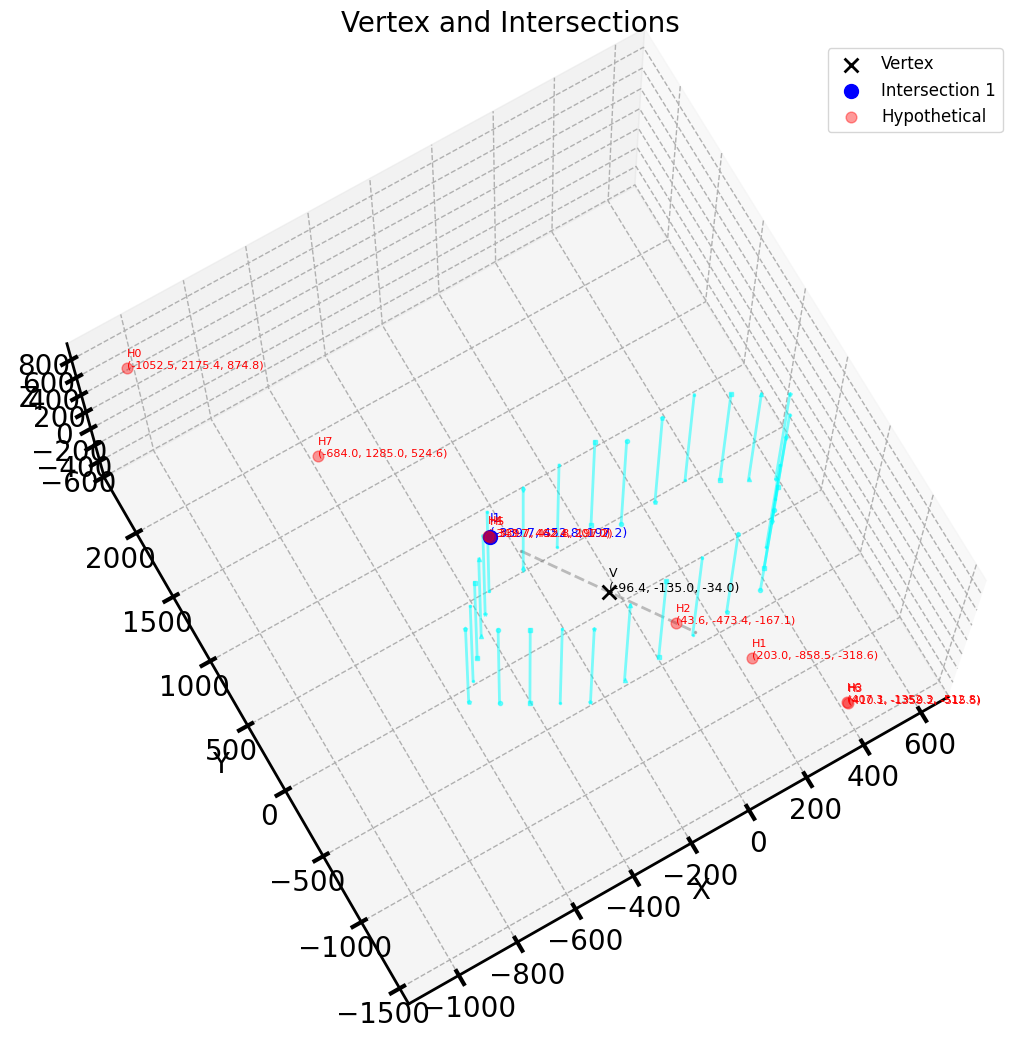


🧊 Event number: 111000100000077


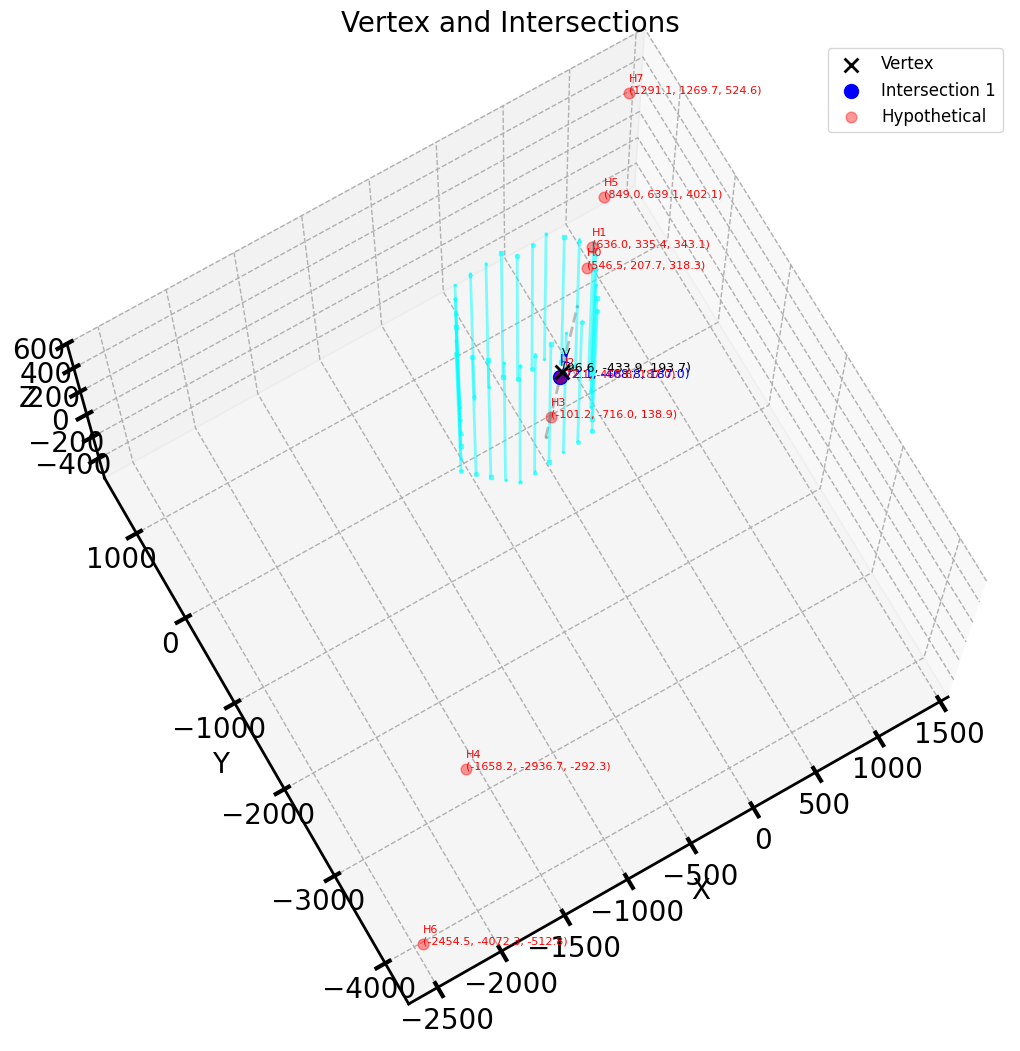


🧊 Event number: 111000100000087


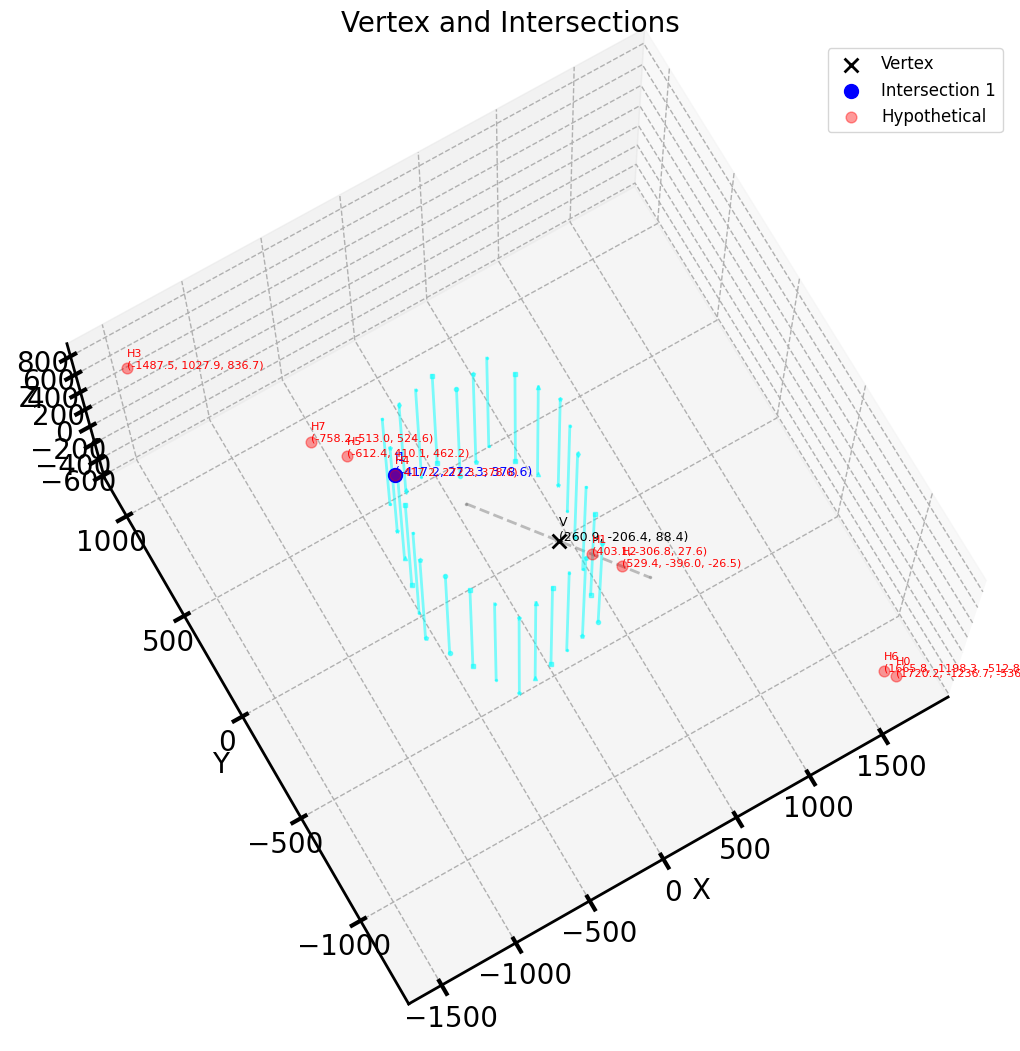


🧊 Event number: 111000100000093


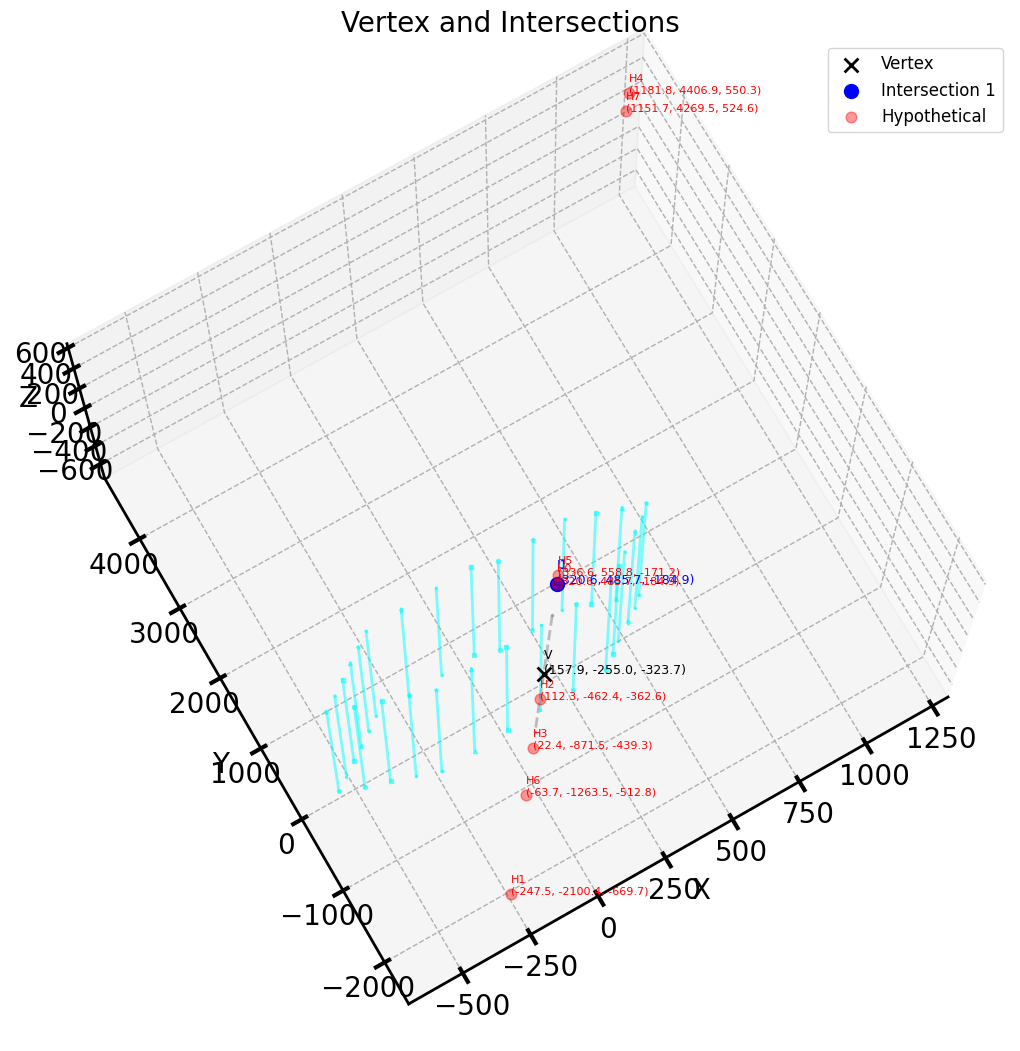


🧊 Event number: 111000100000106


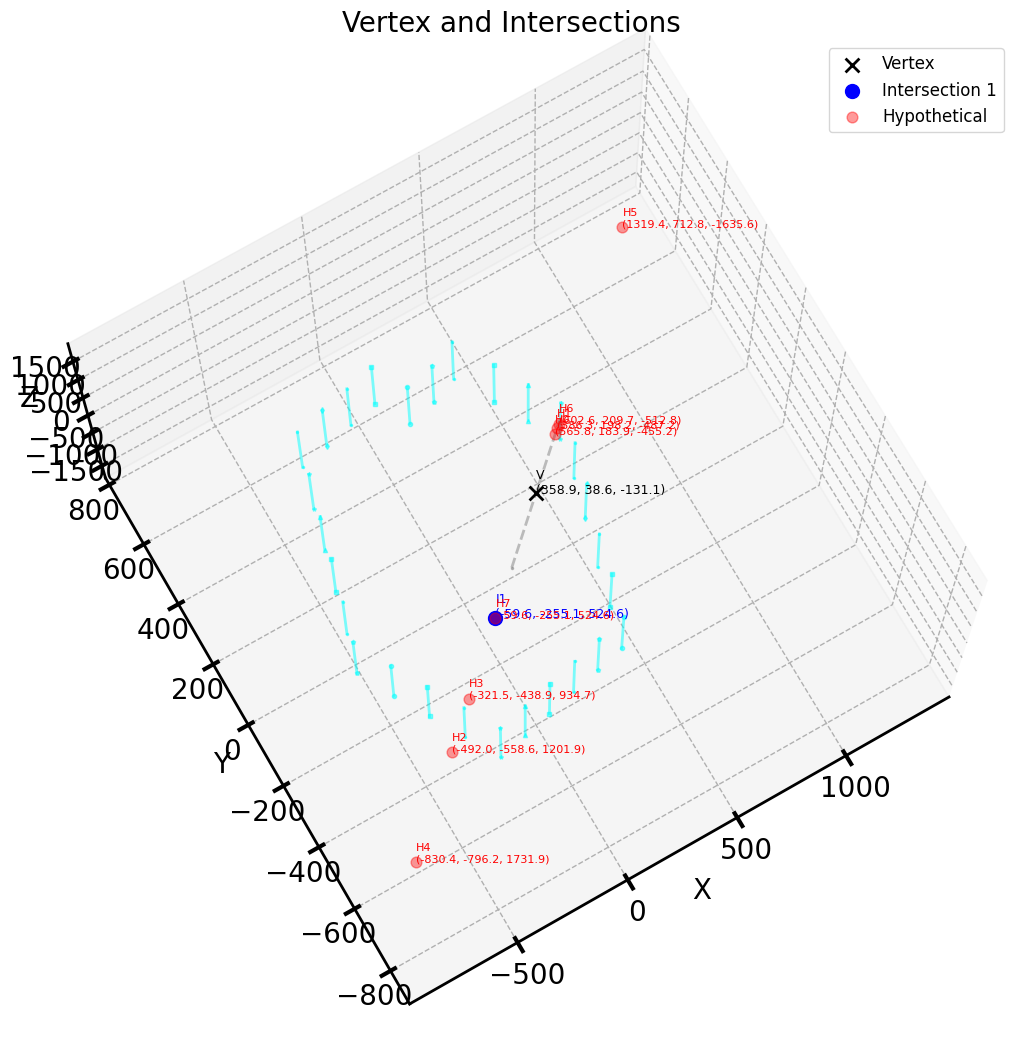

In [56]:
show_peculiar_events(df_TeV_nu_mu_1_truth)

In [ ]:
import numpy as np
from matplotlib.path import Path
# Epsilon for floating point comparisons and checking for collinearity/zero norms
EPSILON = 1e-12
def are_points_collinear(p0, p1, p2):
    """Checks if three 3D points are collinear."""
    v1 = p1 - p0
    v2 = p2 - p0
    # If cross product magnitude is near zero, they are collinear
    cross_prod = np.cross(v1, v2)
    return np.linalg.norm(cross_prod) < EPSILON
def check_coplanar(vertices):
    """Checks if a list of 3D vertices are coplanar."""
    if len(vertices) < 4:
        return True # 3 or fewer points are always coplanar
    p0 = vertices[0]
    # Find two other non-collinear points to define the plane
    p1 = None
    p2 = None
    for i in range(1, len(vertices)):
        if np.linalg.norm(vertices[i] - p0) > EPSILON:
            p1 = vertices[i]
            break
    if p1 is None: return True # All points are coincident with p0
    for i in range(2, len(vertices)):
         # Check if vertices[i] is non-collinear with p0 and p1
        if not are_points_collinear(p0, p1, vertices[i]):
            p2 = vertices[i]
            break
    if p2 is None: return True # All points are collinear
    # Plane defined by p0, p1, p2
    v1 = p1 - p0
    v2 = p2 - p0
    normal = np.cross(v1, v2)
    norm_n = np.linalg.norm(normal)
    if norm_n < EPSILON: return True # Should not happen if p0,p1,p2 non-collinear check worked
    normal = normal / norm_n
    # Check if all other points lie on this plane
    for i in range(3, len(vertices)):
        if abs(np.dot(vertices[i] - p0, normal)) > EPSILON:
            return False
    return True
def is_point_inside_face(point_xyz, face_vertices):
    """
    Checks if a 3D point lies within the boundary of a planar face defined
    by its 3D vertices. Assumes the point lies on the infinite plane
    defined by the face.
    Args:
        point_xyz (array-like): The 3D coordinates (x, y, z) of the point.
        face_vertices (list or np.ndarray): A list or array of 3D vertices
            [(x1,y1,z1), (x2,y2,z2), ...] defining the polygon face in order.
            Must contain at least 3 non-collinear, coplanar vertices.
    Returns:
        bool: True if the point is inside or on the boundary of the face,
              False otherwise.
    Raises:
        ValueError: If inputs are invalid (not 3D, fewer than 3 vertices,
                    vertices not coplanar, vertices collinear).
    """
    point_xyz = np.asarray(point_xyz)
    face_vertices = [np.asarray(v) for v in face_vertices]
    # --- Input Validation ---
    if point_xyz.shape != (3,):
        raise ValueError("Input point must have 3 coordinates (x, y, z).")
    if len(face_vertices) < 3:
        raise ValueError("Face must have at least 3 vertices.")
    if not all(v.shape == (3,) for v in face_vertices):
        raise ValueError("All face vertices must have 3 coordinates (x, y, z).")
    # Check if face vertices are coplanar (essential for the method)
    if not check_coplanar(face_vertices):
         raise ValueError("Face vertices are not coplanar.")
    # --- Define 2D Basis on the Plane ---
    p0 = face_vertices[0]
    p1 = None
    p2 = None
    # Find p1 non-coincident with p0
    for i in range(1, len(face_vertices)):
        if np.linalg.norm(face_vertices[i] - p0) > EPSILON:
            p1 = face_vertices[i]
            break
    if p1 is None:
        # All vertices are coincident, point is inside iff it's the same point
        return np.linalg.norm(point_xyz - p0) < EPSILON
    # Find p2 non-collinear with p0 and p1
    for i in range(1, len(face_vertices)):
        # Check if face_vertices[i] is non-collinear with p0 and p1
        if not are_points_collinear(p0, p1, face_vertices[i]):
            p2 = face_vertices[i]
            break
    if p2 is None:
         # All vertices are collinear. Check if point lies on the segment.
         # This is complex. For simplicity, raise error or return False,
         # as Path requires non-degenerate polygon.
         raise ValueError("Face vertices are collinear, cannot form a 2D Path.")
         # Alternative for line segment check: Check if point is between min/max
         # projection onto the line vector, but point-in-polygon is ill-defined.
    # Create basis vectors
    v1 = p1 - p0
    v2 = p2 - p0 # This v2 is guaranteed not to be parallel to v1
    u = v1 / np.linalg.norm(v1) # First basis vector (along p0->p1)
    # Find component of v2 orthogonal to v1 (using Gram-Schmidt idea)
    v2_ortho = v2 - np.dot(v2, u) * u
    v_norm = np.linalg.norm(v2_ortho)
    if v_norm < EPSILON:
        # This should not happen if p0, p1, p2 were non-collinear. Safety check.
        raise ValueError("Could not find orthogonal basis vectors - vertices might be collinear.")
    v = v2_ortho / v_norm # Second basis vector (orthogonal to u, in plane)
    # --- Project Vertices and Point to 2D ---
    vertices_2d = []
    for p_3d in face_vertices:
        p_relative = p_3d - p0
        coord_u = np.dot(p_relative, u)
        coord_v = np.dot(p_relative, v)
        vertices_2d.append((coord_u, coord_v))
    point_relative = point_xyz - p0
    point_2d = (np.dot(point_relative, u), np.dot(point_relative, v))
    # --- Perform 2D Point-in-Polygon Test ---
    try:
        face_path = Path(vertices_2d)
        is_inside = face_path.contains_point(point_2d, radius=EPSILON) # Use radius for boundary robustness
    except ValueError as e:
        # Should only happen for degenerate paths, caught earlier ideally
        raise ValueError(f"Could not perform Path check: {e}")
    return is_inside
# --- Example Usage ---
# 1. Get the faces data using the provided function
def build_icecube_prism_faces():
    # Faces 0-5 are vertical sides (quadrilaterals)
    ICECUBE_FACES = {
        0: np.array([(269.70961549, 548.30058428, 524.56), (269.70961549, 548.30058428, -512.82),
                     (576.36999512, 170.91999817, -512.82), (576.36999512, 170.91999817, 524.56)]), # Order corrected for Path
        1: np.array([(576.36999512, 170.91999817, 524.56), (576.36999512, 170.91999817, -512.82),
                     (361.0, -422.82998657, -512.82), (361.0, -422.82998657, 524.56)]), # Order corrected
        2: np.array([(361.0, -422.82998657, 524.56), (361.0, -422.82998657, -512.82),
                     (-256.14001465, -521.08001709, -512.82), (-256.14001465, -521.08001709, 524.56)]),# Order corrected
        3: np.array([(-256.14001465, -521.08001709, 524.56), (-256.14001465, -521.08001709, -512.82),
                     (-570.90002441, -125.13999939, -512.82), (-570.90002441, -125.13999939, 524.56)]),# Order corrected
        4: np.array([(-570.90002441, -125.13999939, 524.56), (-570.90002441, -125.13999939, -512.82),
                     (-347.88000488, 451.51998901, -512.82), (-347.88000488, 451.51998901, 524.56)]), # Order corrected
        5: np.array([(-347.88000488, 451.51998901, 524.56), (-347.88000488, 451.51998901, -512.82),
                     (269.70961549, 548.30058428, -512.82), (269.70961549, 548.30058428, 524.56)]) # Order corrected
    }
    # Faces 6-7 are horizontal top/bottom (hexagons)
    # Note: Original dict had keys 0 and 1, renamed to 6 and 7 for uniqueness
    ICECUBE_ENDCAPS = {
        6: np.array([(269.70961549, 548.30058428, -512.82), # Base
                     (576.36999512, 170.91999817, -512.82),
                     (361.0, -422.82998657, -512.82),
                     (-256.14001465, -521.08001709, -512.82),
                     (-570.90002441, -125.13999939, -512.82),
                     (-347.88000488, 451.51998901, -512.82)]),
        7: np.array([(269.70961549, 548.30058428, 524.56), # Top
                     (576.36999512, 170.91999817, 524.56),
                     (361.0, -422.82998657, 524.56),
                     (-256.14001465, -521.08001709, 524.56),
                     (-570.90002441, -125.13999939, 524.56),
                     (-347.88000488, 451.51998901, 524.56)])
    }
    # Combine faces: Make sure order is correct for Path winding if needed
    # Ensure keys don't overlap if combining dicts directly
    all_faces_dict = {**ICECUBE_FACES, **ICECUBE_ENDCAPS}
    # Return a list of the vertex arrays
    return list(all_faces_dict.values())
faces = build_icecube_prism_faces()
# 2. Define some test points (ensure they are on the plane of the face being tested)
# Point known to be on the base face (face 6)
point_on_base = np.array([0, 0, -512.82])
# Point known to be on the top face (face 7)
point_on_top = np.array([0, 0, 524.56])
# Point on side face 0 (between vertices 0 and 1 of that face)
side_face0_vertices = faces[0]
point_on_side0 = (side_face0_vertices[0] + side_face0_vertices[1]) / 2
# Point outside all faces (but maybe on a plane)
point_outside = np.array([1000, 1000, 0])
# Point inside base (face 6), but test against top (face 7) -> should be False
point_base_test_top = np.array([0, 0, -512.82])
# 3. Test the function in a loop (as user intends)
print("--- Testing Point on Base ({}) ---".format(point_on_base))
for i, face in enumerate(faces):
    # Need try-except because point is only guaranteed on one plane
    try:
        # We check coplanarity of the face vertices themselves inside the function.
        # The check on the point being coplanar is skipped as requested,
        # BUT the projection math implicitly assumes it IS coplanar.
        # If the point is not coplanar, the 2D projection might give
        # misleading results, but we follow the user's constraint.
        is_inside = is_point_inside_face(point_on_base, face)
        if is_inside:
            print(f"Point is INSIDE face {i}")
        # else:
        #     print(f"Point is OUTSIDE face {i}") # Too verbose
    except ValueError as e:
        print(f"Skipping face {i} due to error: {e}") # e.g. if face is degenerate
print("\n--- Testing Point on Top ({}) ---".format(point_on_top))
for i, face in enumerate(faces):
    try:
        is_inside = is_point_inside_face(point_on_top, face)
        if is_inside:
            print(f"Point is INSIDE face {i}")
    except ValueError as e:
        print(f"Skipping face {i} due to error: {e}")
print("\n--- Testing Point on Side 0 ({}) ---".format(point_on_side0))
for i, face in enumerate(faces):
    try:
        is_inside = is_point_inside_face(point_on_side0, face)
        if is_inside:
             print(f"Point is INSIDE face {i}") # Should be inside face 0 (boundary)
    except ValueError as e:
        print(f"Skipping face {i} due to error: {e}")
print("\n--- Testing Point Outside ({}) ---".format(point_outside))
found_inside = False
for i, face in enumerate(faces):
     try:
        # This point isn't guaranteed to be on any plane, so results might be odd,
        # but we test according to user's "no coplanar check" rule.
        is_inside = is_point_inside_face(point_outside, face)
        if is_inside:
            print(f"Point is INSIDE face {i} (Unexpected for this point)")
            found_inside = True
     except ValueError as e:
        print(f"Skipping face {i} due to error: {e}")
if not found_inside:
    print("Point is OUTSIDE all faces (as expected).")

In [ ]:
pos = np.stack([pos_x, pos_y, pos_z], axis=1)
dir_vec = np.stack([x_dir_daugther, y_dir_daugther, z_dir_daugther], axis=1)
faces = build_icecube_prism_faces()
num_intersections = []
for p, d in zip(pos, dir_vec):
    intersections = []
    for face in faces:
        point = compute_intersection_with_plane(p, d, face)
        if point is not None:
            if is_point_inside_face(point, face):
                intersections.append(point)
    if len(intersections) > 2:
        print("More than 2 intersections found for point:", p, "dir:", d)
        print("Intersections:", intersections)
    num_intersections.append(len(intersections))
num_intersections = np.array(num_intersections)